# Process 0.5˚ GPWv4 Netcdf to create a population-only file and add intermediate years

- Use the pre-processed NASA population data which is already on the 0.5˚ grid instead of doing this custom.

- We also want to use the demographic data provided in the same way

- First want to interpolate the population to all years

## Note on pixel coordinates and transform to ERA coordinates

The coordinate system used by GPW doesn't match the one used by ERA-Interim: ERA uses 0-360 longitude . GPW uses -180 to 180, so they are offset by 180deg relative to the ERA files.

GPW also has a different cell referencing, you can see best in the 30min netcdf files because the coords are e.g. 0.25, 0.75 etc while ERA is 0, 0.5 etc.

GPW is based on the 'pixel is area' convention which we can prove because reading the tags in the TIFF files we see  the entry `'AREA_OR_POINT': 'Area'`

At a best estimate, ERA values (it seems) refer to the top-left of the grid cells. LLet us anyway make this simplifying assumption, because then to transform GPW to ERA grid just means re-labelling the axes of the NETCDF files such that the lat/lon coords also refer to the top-left corder instead of the centre - basically just need to shift the values by 0.25degrees.

NOTE THAT for the previous years, we projected the weather data onto the high resolution population data. Since the population data was such high resolution it didn't actually matter wether we referred to the grid centre or corner because we could treat the pixels as points anyway. With the new approach we want to align everything to 0.5degree resolution which makes everything much simpler.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import rasterio
import xarray as xr
import matplotlib.pyplot as plt

from config import POP_DATA_SRC, DATA_SRC

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

In [3]:
metadata = pd.read_csv(POP_DATA_SRC / 'gpwv4' / 'gpw_v4_netcdf_contents.csv')

In [5]:
metadata[metadata.file_name == 'gpw_v4_e_atotpopbt_cntm']

file_name  order  \
0   gpw_v4_e_atotpopbt_cntm      1   
1   gpw_v4_e_atotpopbt_cntm      2   
2   gpw_v4_e_atotpopbt_cntm      3   
3   gpw_v4_e_atotpopbt_cntm      4   
4   gpw_v4_e_atotpopbt_cntm      5   
5   gpw_v4_e_atotpopbt_cntm      6   
6   gpw_v4_e_atotpopbt_cntm      7   
7   gpw_v4_e_atotpopbt_cntm      8   
8   gpw_v4_e_atotpopbt_cntm      9   
9   gpw_v4_e_atotpopbt_cntm     10   
10  gpw_v4_e_atotpopbt_cntm     11   
11  gpw_v4_e_atotpopbt_cntm     12   
12  gpw_v4_e_atotpopbt_cntm     13   
13  gpw_v4_e_atotpopbt_cntm     14   
14  gpw_v4_e_atotpopbt_cntm     15   
15  gpw_v4_e_atotpopbt_cntm     16   

                                    raster_name  \
0                Population Count, v4.10 (2000)   
1                Population Count, v4.10 (2005)   
2                Population Count, v4.10 (2010)   
3                Population Count, v4.10 (2015)   
4                Population Count, v4.10 (2020)   
5                    Data Context, v4.10 (2010)   
6             Type of Tabular Input Data, v4.10   
7                       Input Data Level, v4.10   
8                        Input Data Year, v4.10   
9                   Growth Rate End Year, v4.10   
10      Growth Rate Administrative Level, v4.10   
11                Growth Rate Start Year, v4.10   
12            Year of Most Recent Census, v4.10   
13  Mean Administrative Unit Area, v4.10 (2010)   
14       National Identifier Grid, v4.10 (2010)   
15                     Water Mask, v4.10 (2010)   

                                   raster_description  
0                  Population count for the year 2000  
1                  Population count for the year 2005  
2                  Population count for the year 2010  
3                  Population count for the year 2015  
4                  Population count for the year 2020  
5   Categorizes pixels with estimated 0 population...  
6   A code referencing the type of population data...  
7     Highest administrative level of input data used  
8          The year of the input population data used  
9   The latest year used to calculate the annual e...  
10  The dominant administrative level used to calc...  
11  The earliest year used to calculate the annual...  
12  Year of the most recent census conducted in th...  
13  Mean administrative unit area in square kilome...  
14  Numeric country codes corresponding to nation-...  
15  Displays pixels that are completely or partial...

# Extract, interpolate the population data and adjust coordinates to match the ERA-Interim dataset


In [6]:
dat = xr.open_dataarray(POP_DATA_SRC / 'gpwv4'/'gpw_v4_une_atotpopbt_cntm_30_min.nc')
dat.name = 'population'
width = len(dat.longitude)

In [7]:
# Select only the 1st 5 rasters which correspond to the year counts
pop = dat.sel(raster=[1,2,3,4,5]).copy()

Translate (roll) the dataset from the -180 to 180 range to the 0 to 360 range and re-label the longitude

Also re-label the latitude to refer to the top-left grid cell, simply shift it UP by 0.25 degrees


In [7]:
pop = pop.roll(longitude=-width // 2, roll_coords=False)
pop['longitude'] = np.arange(0, 360, 0.5)

pop['latitude'] += 0.25

Re-label the year dimension and give it actual year values instead of raster layer numbers

In [8]:
pop['raster'] = 2000 + 5*(pop.raster-1)
pop = pop.rename({'raster':'year'})
pop['year'] = pop.year.astype(np.int32)

In [9]:
pop = pop.interp(year=(np.arange(2000, 2021)))

In [9]:
# Save as dataset
pop.to_dataset().to_netcdf(POP_DATA_SRC / 'population_count_2000-2020_30min_era_compat.nc')

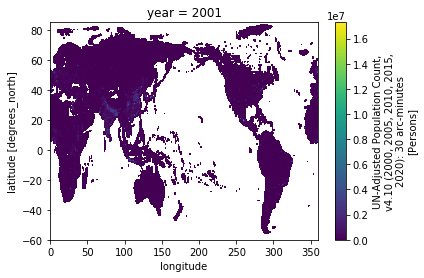

In [10]:
pop.sel(year=2001).plot()
plt.show()

In [11]:
with rasterio.open(POP_DATA_SRC / 'gpwv4' / 'gpw-v4-land-water-area-rev10_landareakm_30_min_tif' / 'gpw_v4_land_water_area_rev10_landareakm_30_min.tif') as file:
    print(file.tags())
    water = file.read()

{'AREA_OR_POINT': 'Area', 'DataType': 'Generic'}


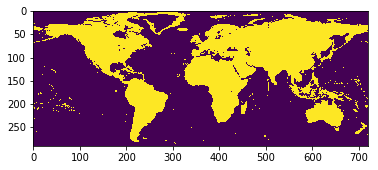

In [12]:
plt.imshow(np.squeeze(water))
plt.show()

# Open and re-coordainate and re-save the water mask data

In [9]:
land = xr.open_rasterio(POP_DATA_SRC / 'gpwv4'/ 'gpw-v4-land-water-area-rev10_landareakm_30_min_tif' / 'gpw_v4_land_water_area_rev10_landareakm_30_min.tif')
land = land.rename({'x':'longitude', 'y':'latitude', 'band': 'land_water_area'})

In [10]:
land = land.squeeze(drop=True)
land.name = 'land_water_area'

In [11]:
land = len(land.longitude)
land = land.roll(longitude=-width // 2, roll_coords=False)
land['longitude'] = np.arange(0, 360, 0.5)
land['latitude'] = pop['latitude']

In [12]:
land = land.where(land != land.nodatavals[0])

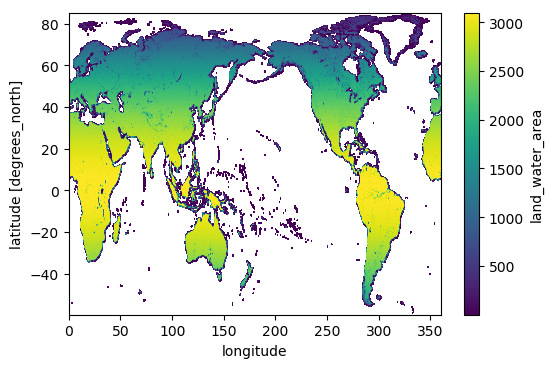

In [13]:
land.plot()

In [14]:
land.to_dataset().to_netcdf(POP_DATA_SRC / 'land_mask_30min_era_compat.nc')

## Open and re-coordinate the country code grid

In [8]:
countries = xr.open_rasterio(POP_DATA_SRC / 'gpwv4'/ 'gpw-v4-national-identifier-grid-rev11_30_min_tif' / 'gpw_v4_national_identifier_grid_rev11_30_min.tif')
countries = countries.rename({'x':'longitude', 'y':'latitude', 'band': 'country_codes'})

In [16]:
countries = countries.squeeze(drop=True)
countries = countries.to_dataset(name='country_codes')

In [17]:
countries

<xarray.Dataset>
Dimensions:        (latitude: 360, longitude: 720)
Coordinates:
  * latitude       (latitude) float64 89.75 89.25 88.75 ... -88.75 -89.25 -89.75
  * longitude      (longitude) float64 -179.8 -179.2 -178.8 ... 179.2 179.8
Data variables:
    country_codes  (latitude, longitude) int16 ...

In [18]:
width = len(countries.longitude)
countries = countries.roll(longitude=-width // 2, roll_coords=False)
countries['longitude'] = np.arange(0, 360, 0.5)
countries['latitude'] = np.arange(90, -90, -0.5)

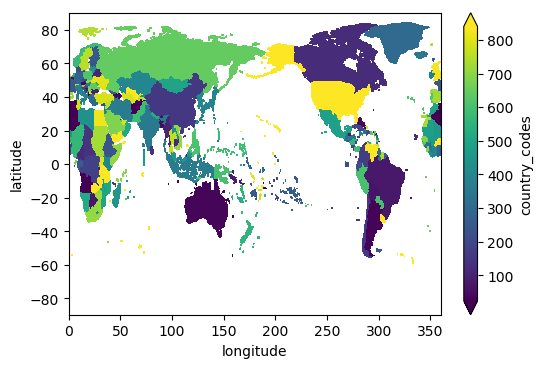

In [19]:
# Water is marked as code 3000something
countries.country_codes.where(countries.country_codes < 3000).plot(robust=True)

In [20]:
countries.to_netcdf(POP_DATA_SRC / 'country_codes_30min_era_compat.nc')

## Generate grids for the European Union (EU28/27)

> Don't forget to update post-Brexit >_<


In [9]:
COUNTRIES_RASTER = xr.open_dataset(POP_DATA_SRC / 'country_codes_30min_era_compat.nc').load()

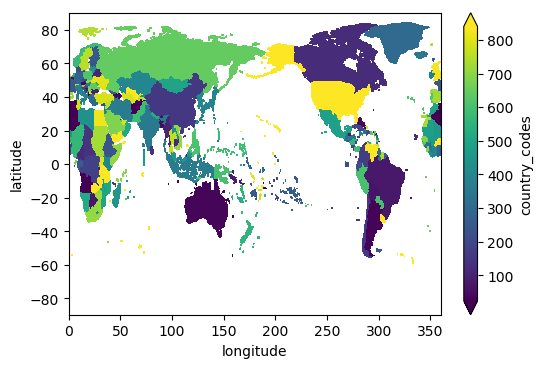

In [20]:
COUNTRIES_RASTER.country_codes.where(COUNTRIES_RASTER.country_codes < 3000).plot(robust=True)

In [23]:
# Define the countries that are in the European Union
# https://www.kaweb.co.uk/blog/list-eu-countries-and-iso-3166-1-alpha-3-code/
COUNTRY_CODES_EU = 'AUT, BEL, BGR, HRV, CYP, CZE, DNK, EST, FIN, FRA, DEU, GRC, HUN, IRL, ITA, LVA, LTU, LUX, MLT, NLD, POL, PRT, ROU, SVK, SVN, ESP, SWE, GBR'
COUNTRY_CODES_EU = COUNTRY_CODES_EU.split(',')
COUNTRY_CODES_EU = [c.strip() for c in COUNTRY_CODES_EU]

In [24]:
COUNTRY_ID_LOOKUP = DATA_SRC/ 'lancet/population/gpw_v4_national_identifier_lookup.txt'
COUNTRIES_LOOKUP = pd.read_csv(COUNTRY_ID_LOOKUP,sep='\t')

In [25]:
COUNTRIES_EU = COUNTRIES_LOOKUP[COUNTRIES_LOOKUP.ISOCODE.isin(COUNTRY_CODES_EU)]

In [26]:
country_mask =None
for _, row in COUNTRIES_EU.iterrows():
    grid_code = row.GRIDCODE
    if country_mask is None:
        country_mask = COUNTRIES_RASTER.country_codes == grid_code
    else:
        # Combine the country mask of the current country with the overall one
        # using bitwise 'OR'
        _cmask = COUNTRIES_RASTER.country_codes == grid_code
        country_mask = country_mask | _cmask

In [27]:
country_mask.to_netcdf(POP_DATA_SRC / 'countries_eu28_30min_era_compat.nc')

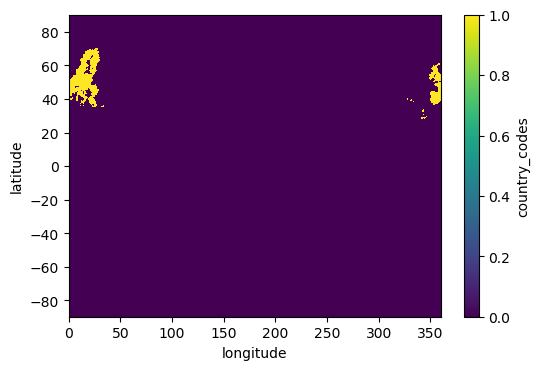

In [28]:
country_mask.plot()

# Generate a raster for WHO regions

In [21]:
WORLD_STAT_SRC = DATA_SRC / 'lancet' / 'world stats'

In [30]:
country_data = pd.read_excel(WORLD_STAT_SRC/ 'HWF_0001,HWF_0002,HWF_0003,HWF_0004,HWF_0005.xlsx', sheet_name='Country')
# country_data = country_data[['Code', 'DisplayValue','LAND_AREA_KMSQ_2012','WHO_REGION', 'World Bank income group']]
country_data.head()

Code DisplayValue  URL   DS FIPS  IOC ISO2  ISO  ITU MARC  ...  \
0  AFG  Afghanistan  NaN  AFG   AF  AFG   AF  AFG  AFG   af  ...   
1  ALB      Albania  NaN   AL   AL  ALB   AL  ALB  ALB   aa  ...   
2  DZA      Algeria  NaN   DZ   AG  ALG   DZ  DZA  ALG   ae  ...   
3  AND      Andorra  NaN  AND   AN  AND   AD  AND  AND   an  ...   
4  AGO       Angola  NaN  NaN   AO  ANG   AO  AGO  AGL   ao  ...   

                                   LANGUAGES_EN_2012             WHO_REGION  \
0  Dari, Pashto, Turkic languages, 30 minor langu...  Eastern Mediterranean   
1    Albanian, Greek, Vlach, Romani, Slavic dialects                 Europe   
2                    Arabic, French, Berber dialects                 Africa   
3            Catalan, French, Castilian, Portuguese                  Europe   
4       Portuguese, Bantu,  other African languages                  Africa   

  WHO_REGION_CODE  World Bank income group World Bank income group code  \
0             EMR               Low income                        WB_LI   
1             EUR      Upper middle income                       WB_UMI   
2             AFR      Upper middle income                       WB_UMI   
3             EUR              High income                        WB_HI   
4             AFR      Lower middle income                       WB_LMI   

  SHORTNAMEES  SHORTNAMEFR WHOLEGALSTATUS  \
0  Afganistan  Afghanistan              M   
1     Albania      Albanie              M   
2     Argelia      Algérie              M   
3     Andorra      Andorre              M   
4      Angola       Angola              M   

  World Bank income group GNI reference year  \
0                                       2017   
1                                       2017   
2                                       2017   
3                                       2017   
4                                       2017   

  World Bank income group release date  
0                                 2018  
1                                 2018  
2                                 2018  
3                                 2018  
4                                 2018  

[5 rows x 25 columns]

In [28]:
COUNTRY_ID_LOOKUP = POP_DATA_SRC / 'gpwv4/gpw_v4_national_identifier_lookup.txt'
COUNTRIES_LOOKUP = pd.read_csv(COUNTRY_ID_LOOKUP,sep='\t')

In [32]:
COUNTRIES_LOOKUP = COUNTRIES_LOOKUP.set_index('ISOCODE').join(country_data[['ISO', 'WHO_REGION']].set_index('ISO'))

In [47]:
results = {}
who_regions = COUNTRIES_LOOKUP.WHO_REGION.unique()

for region in who_regions:
    if isinstance(region, float ):
        continue
    region_countries = COUNTRIES_LOOKUP[COUNTRIES_LOOKUP.WHO_REGION == region]
    country_mask = None
    for _, row in region_countries.iterrows():
        grid_code = row.GRIDCODE
        if country_mask is None:
            country_mask = COUNTRIES_RASTER.country_codes == grid_code
        else:
            # Combine the country mask of the current country with the overall one
            # using bitwise 'OR'
            _cmask = COUNTRIES_RASTER.country_codes == grid_code
            country_mask = country_mask | _cmask
            
    results[region] = country_mask
    
results = xr.Dataset(results)

In [50]:
results.to_netcdf(POP_DATA_SRC / 'who_regions_30min_era_compat.nc')

# Process the demographic data

Remove redundant information, save both demographic totals and percentages

## TODO/NOTE: NASA gives the demographics fro 2010. By combining with the UN population model we could try to provide adjustment vectors for each county over time, to give demographic time series.

In [4]:
metadata[metadata.file_name == 'gpw_v4_basic_demographic_characteristics_bt_cntm']

file_name  order  \
64  gpw_v4_basic_demographic_characteristics_bt_cntm      1   
65  gpw_v4_basic_demographic_characteristics_bt_cntm      2   
66  gpw_v4_basic_demographic_characteristics_bt_cntm      3   
67  gpw_v4_basic_demographic_characteristics_bt_cntm      4   
68  gpw_v4_basic_demographic_characteristics_bt_cntm      5   
69  gpw_v4_basic_demographic_characteristics_bt_cntm      6   
70  gpw_v4_basic_demographic_characteristics_bt_cntm      7   
71  gpw_v4_basic_demographic_characteristics_bt_cntm      8   
72  gpw_v4_basic_demographic_characteristics_bt_cntm      9   
73  gpw_v4_basic_demographic_characteristics_bt_cntm     10   
74  gpw_v4_basic_demographic_characteristics_bt_cntm     11   
75  gpw_v4_basic_demographic_characteristics_bt_cntm     12   
76  gpw_v4_basic_demographic_characteristics_bt_cntm     13   
77  gpw_v4_basic_demographic_characteristics_bt_cntm     14   
78  gpw_v4_basic_demographic_characteristics_bt_cntm     15   
79  gpw_v4_basic_demographic_characteristics_bt_cntm     16   
80  gpw_v4_basic_demographic_characteristics_bt_cntm     17   
81  gpw_v4_basic_demographic_characteristics_bt_cntm     18   
82  gpw_v4_basic_demographic_characteristics_bt_cntm     19   
83  gpw_v4_basic_demographic_characteristics_bt_cntm     20   
84  gpw_v4_basic_demographic_characteristics_bt_cntm     21   
85  gpw_v4_basic_demographic_characteristics_bt_cntm     22   
86  gpw_v4_basic_demographic_characteristics_bt_cntm     23   
87  gpw_v4_basic_demographic_characteristics_bt_cntm     24   
88  gpw_v4_basic_demographic_characteristics_bt_cntm     25   
89  gpw_v4_basic_demographic_characteristics_bt_cntm     26   

                                          raster_name  \
64                     Population Count, v4.10 (2010)   
65  Basic Demographic Characteristics, v4.10 (2010...   
66  Basic Demographic Characteristics, v4.10 (2010...   
67  Basic Demographic Characteristics, v4.10 (2010...   
68  Basic Demographic Characteristics, v4.10 (2010...   
69  Basic Demographic Characteristics, v4.10 (2010...   
70  Basic Demographic Characteristics, v4.10 (2010...   
71  Basic Demographic Characteristics, v4.10 (2010...   
72  Basic Demographic Characteristics, v4.10 (2010...   
73  Basic Demographic Characteristics, v4.10 (2010...   
74  Basic Demographic Characteristics, v4.10 (2010...   
75  Basic Demographic Characteristics, v4.10 (2010...   
76  Basic Demographic Characteristics, v4.10 (2010...   
77  Basic Demographic Characteristics, v4.10 (2010...   
78  Basic Demographic Characteristics, v4.10 (2010...   
79                         Data Context, v4.10 (2010)   
80                  Type of Tabular Input Data, v4.10   
81                            Input Data Level, v4.10   
82                             Input Data Year, v4.10   
83                        Growth Rate End Year, v4.10   
84            Growth Rate Administrative Level, v4.10   
85                      Growth Rate Start Year, v4.10   
86                  Year of Most Recent Census, v4.10   
87        Mean Administrative Unit Area, v4.10 (2010)   
88             National Identifier Grid, v4.10 (2010)   
89                           Water Mask, v4.10 (2010)   

                                   raster_description  
64                 Population count for the year 2010  
65     Population count ages 0 to 4 for the year 2010  
66     Population count ages 5 to 9 for the year 2010  
67   Population count ages 10 to 14 for the year 2010  
68   Population count ages 15 to 19 for the year 2010  
69   Population count ages 20 to 24 for the year 2010  
70   Population count ages 25 to 29 for the year 2010  
71   Population count ages 30 to 34 for the year 2010  
72   Population count ages 35 to 39 for the year 2010  
73   Population count ages 40 to 44 for the year 2010  
74   Population count ages 45 to 49 for the year 2010  
75   Population count ages 50 to 54 for the year 2010  
76   Population count ages 55 to 59 for the year 2010  
77   Population c

In [11]:
demog = xr.open_dataarray(POP_DATA_SRC / 'gpwv4' / 'gpw_v4_basic_demographic_characteristics_bt_cntm_30_min.nc')

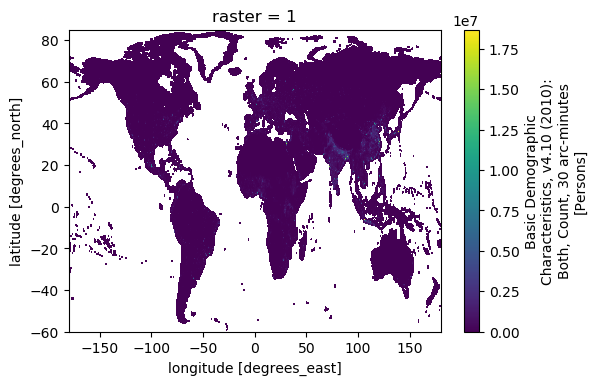

In [12]:
demog.sel(raster=1).plot()

> Pull out the percentage data before going on to process the demographic data (this is just because it was added later, avoid re-doing everything)

In [19]:
demog_pcts = (demog.sel(raster=np.arange(2, 15+1)) / demog.sel(raster=1)).copy()

In [13]:
demog = demog.sel(raster=np.arange(2, 15+1))
demog['raster'] =  np.arange(0, 70, 5)
demog = demog.rename({'raster':'age_band_lower_bound'})
demog['age_band_lower_bound'] = demog.age_band_lower_bound.astype(np.int32)


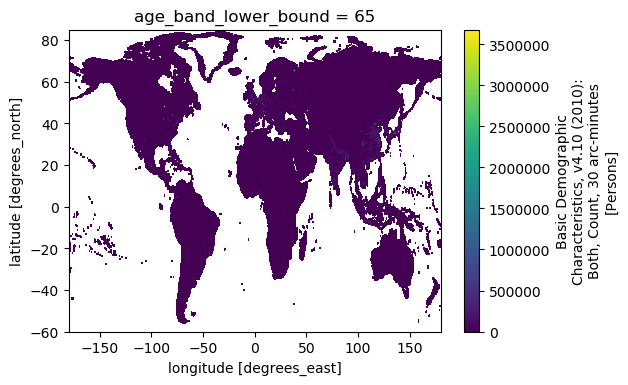

In [14]:
demog.sel(age_band_lower_bound=65).plot()

In [17]:
width = len(demog.longitude)
demog = demog.roll(longitude=-width // 2, roll_coords=False)
demog['longitude'] = np.arange(0, 360, 0.5)
demog['latitude'] += 0.25

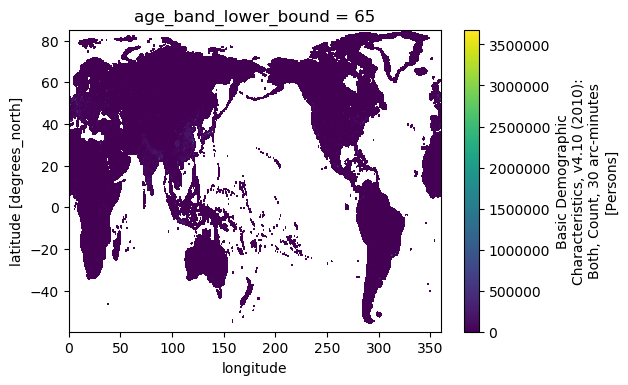

In [20]:
demog.sel(age_band_lower_bound=65).plot()

In [21]:
demog.to_dataset().to_netcdf(POP_DATA_SRC / 'demographic_2010_30min_era_compat.nc')

### Now do the percentages

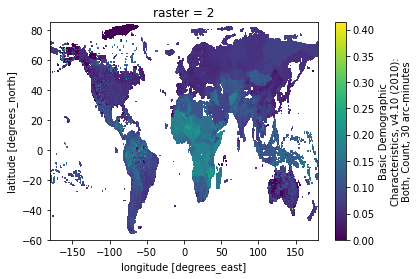

In [7]:
demog_pcts.sel(raster=2).plot()

In [8]:
demog_pcts['raster'] =  np.arange(0, 70, 5)
demog_pcts = demog_pcts.rename({'raster':'age_band_lower_bound'})
demog_pcts['age_band_lower_bound'] = demog_pcts.age_band_lower_bound.astype(np.int32)

Translate (roll) the dataset from the -180 to 180 range to the 0 to 360 range and re-label the longitude

Also re-label the latitude to refer to the top-left grid cell, simply shift it UP by 0.25 degrees


In [9]:
width = len(demog_pcts.longitude)
demog_pcts = demog_pcts.roll(longitude=-width // 2, roll_coords=False)
demog_pcts['longitude'] = np.arange(0, 360, 0.5)

demog_pcts['latitude'] += 0.25

In [10]:
demog_pcts.name = 'fraction_population_in_age_band'

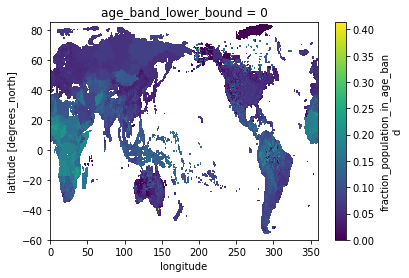

In [11]:
demog_pcts.sel(age_band_lower_bound=0).plot()

In [13]:
demog_pcts.to_dataset().to_netcdf(POP_DATA_SRC / 'demographic_pct_2010_30min_era_compat.nc')